# We're going to look to the raw data

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

# EDA

## Read data

In [24]:
filenames = glob.glob('../data/raw/dataset/*')
filenames

['../data/raw/dataset/data-1.tfrecord',
 '../data/raw/dataset/data-0.tfrecord',
 '../data/raw/dataset/data-2.tfrecord',
 '../data/raw/dataset/data-3.tfrecord']

In [25]:
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [53]:
def _parse_tf_records(element):
    # Parse the input `tf.train.Example` proto using the dictionary schema.
    schema = {
            "userIndex": tf.io.FixedLenFeature([], tf.int64),
            "movieIndices": tf.io.RaggedFeature(tf.int64, row_splits_dtype=tf.int64),
            "timestamps": tf.io.RaggedFeature(tf.int64, row_splits_dtype=tf.int64)
    }
    content = tf.io.parse_single_example(element, schema)
    return content

In [54]:
parsed_tf_records = raw_dataset.map(_parse_tf_records)

df = pd.DataFrame(
    parsed_tf_records.as_numpy_iterator(),
    columns=['userIndex', 'movieIndices', 'timestamps']
)
df.head()

,userIndex,movieIndices,timestamps
0,49744,"[2612, 190, 7780, 1279, 2593, 934]","[946265827, 946265827, 946266411, 946266496, 9..."
1,49745,"[813, 171, 1234, 1580, 43, 57, 1013, 175, 178,...","[941372629, 941372708, 941372708, 941372708, 9..."
2,49746,"[40, 46, 1191, 44, 158, 49, 1190, 528, 574, 39...","[837170891, 837170944, 837170987, 837170987, 8..."
3,49747,"[162, 51, 175, 109, 1016, 169, 994]","[1546520504, 1546520514, 1546520519, 154652056..."
4,49748,"[4957, 29, 10070, 8257, 2160, 18, 432, 9133, 7...","[1476643481, 1476643487, 1476643874, 147664402..."


In [7]:
df.userIndex.nunique()

137068

In [8]:
df[df.userIndex==2].movieIndices.values

array([array([170, 171, 298, 282, 316, 330, 148, 301, 304, 289, 320, 328, 337,
              300, 287, 293, 451, 216])                                       ,
       array([166, 453, 209, 159, 161, 153, 155, 454, 156, 178, 461, 226, 172,
              247, 191, 193, 261, 176, 274, 234, 201, 150, 463, 459, 438, 439,
              429, 416, 352, 188, 275])                                       ,
       array([355, 399, 374, 359, 383, 386, 462, 464])], dtype=object)

__remark__: There are duplicates of same user. It seems that the records where splitted in a chronological way. Let's fix it

## Clean duplicates

In [9]:
def _create_ts_col_sort(df: pd.DataFrame):
    return (
        df
        .assign(seq_timestamps = pd.to_datetime(df.timestamps.apply(lambda x: x[0]), unit='s'))
        .sort_values('seq_timestamps')
        .reset_index(drop=True)
        .drop(columns=['seq_timestamps'])
    )


def _group_by_userIndex(df):
    return (
        df.groupby('userIndex').agg({
            'movieIndices': lambda x: list(np.concatenate(x.values)),
            'timestamps': lambda x: list(np.concatenate(x.values))
        })
        .reset_index()
        .sort_values(by='userIndex')
    )

In [10]:
df = (
    df
    .pipe(_create_ts_col_sort)
    .pipe(_group_by_userIndex)
)

In [11]:
df

,userIndex,movieIndices,timestamps
0,0,"[22, 6, 5, 25, 12, 3, 26, 14, 34, 21, 1, 4, 32...","[1147868053, 1147868097, 1147868414, 114786846..."
1,2,"[170, 171, 298, 282, 316, 330, 148, 301, 304, ...","[1453904021, 1453904031, 1453904046, 145390404..."
2,3,"[165, 470, 512, 181, 185, 475, 471, 476, 473, ...","[1573942880, 1573943155, 1573943272, 157394359..."
3,4,"[40, 0, 533, 540, 527, 528, 530, 151, 529, 517...","[830786155, 830786155, 830786193, 830786193, 8..."
4,5,"[558, 162, 562, 43, 51, 44, 158, 557, 58, 561,...","[945141564, 945141827, 945141942, 945142152, 9..."
...,...,...,...
137063,162335,"[546, 782, 51, 1192, 1216, 694, 1938, 1605, 67...","[944960871, 944960871, 944960967, 944961024, 9..."
137064,162336,"[0, 44, 166, 1430, 4373, 4374, 15723, 109, 335...","[1572257729, 1572257742, 1572257747, 157225775..."
137065,162339,"[627, 705, 60, 1051, 780, 557, 831, 3580, 208,...","[995149720, 995149760, 995149788, 995149788, 9..."
137066,162340,"[360, 25, 141, 116, 3203, 966, 3220, 3699]","[1249028189, 1249028584, 1249028593, 124902967..."


## Some analysis

In [12]:
indices_len = df.movieIndices.apply(len)

In [13]:
indices_len.value_counts()

16     3794
17     3783
15     3726
19     3636
14     3621
       ... 
496       1
584       1
585       1
653       1
470       1
Name: movieIndices, Length: 555, dtype: int64

In [17]:
indices_len.describe()

count    137068.000000
mean         38.296101
std          44.072684
min           4.000000
25%          16.000000
50%          27.000000
75%          44.000000
max        1746.000000
Name: movieIndices, dtype: float64

<AxesSubplot:ylabel='Density'>

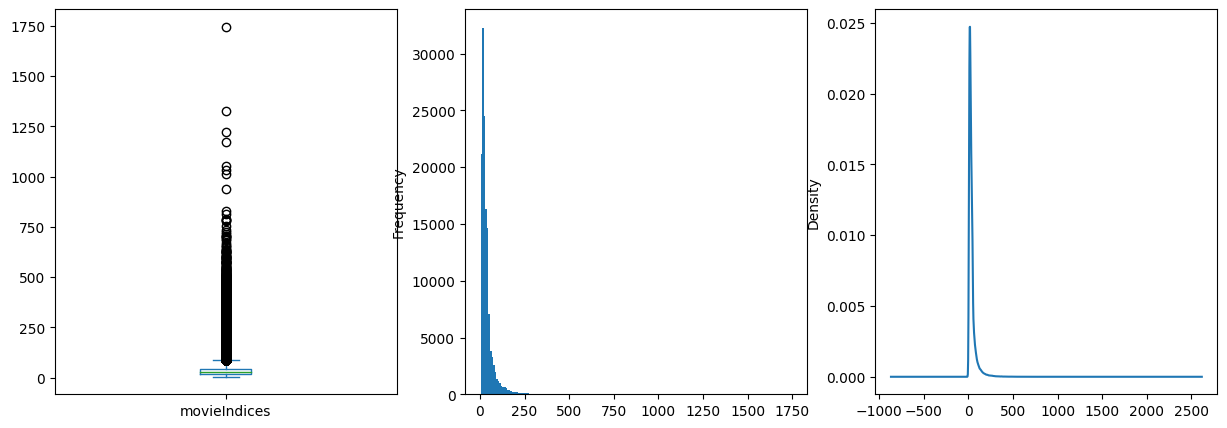

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
indices_len.plot.box(ax=ax1)
indices_len.plot.hist(ax=ax2, bins=200)
indices_len.plot.kde(ax=ax3)

## Write data to interim and replace by token

In [18]:
def _create_tf_records(features):
    tf_example = tf.train.Example(
        features=tf.train.Features(feature={
            'userIndex': tf.train.Feature(bytes_list=tf.train.int64List(
                value=[features[0]])),
            'movieIndices': tf.train.Feature(int64_list=tf.train.Int64List(
                value=[features[1]])),
            'timestamps': tf.train.Feature(int64_list=tf.train.Int64List(
                value=features[2])),
    }))
    return tf_example

In [ ]:
with tf.io.TFRecordWriter("../data/interim/raw_no_duplicates.tfrecords") as writer:
    for i in tqdm(range(df.shape[0])):
        row_series = df.iloc[i, :]
        tf_example = _create_tf_records(row_series)
        writer.write(tf_example.SerializeToString())